# Projectile Motion with Air Resistance

## Theoretical Background

### Ideal Projectile Motion

In the absence of air resistance, projectile motion is governed solely by gravity. The equations of motion are:

$$\frac{d^2 x}{dt^2} = 0$$

$$\frac{d^2 y}{dt^2} = -g$$

where $g \approx 9.81 \, \text{m/s}^2$ is the acceleration due to gravity.

### Air Resistance (Drag Force)

In reality, a projectile experiences a drag force due to air resistance. For moderate speeds, the drag force is proportional to the square of the velocity (quadratic drag):

$$\vec{F}_\text{drag} = -\frac{1}{2} C_D \rho A |\vec{v}| \vec{v}$$

where:
- $C_D$ is the drag coefficient (dimensionless)
- $\rho$ is the air density ($\approx 1.225 \, \text{kg/m}^3$ at sea level)
- $A$ is the cross-sectional area of the projectile
- $\vec{v}$ is the velocity vector

### Equations of Motion with Drag

For a projectile of mass $m$, Newton's second law gives:

$$m\frac{d\vec{v}}{dt} = m\vec{g} + \vec{F}_\text{drag}$$

Defining the drag parameter $b = \frac{1}{2} \frac{C_D \rho A}{m}$, the component equations become:

$$\frac{dv_x}{dt} = -b |\vec{v}| v_x$$

$$\frac{dv_y}{dt} = -g - b |\vec{v}| v_y$$

where $|\vec{v}| = \sqrt{v_x^2 + v_y^2}$.

These coupled, nonlinear ordinary differential equations do not have analytical solutions and must be solved numerically.

### Terminal Velocity

When a projectile falls vertically, it reaches terminal velocity when drag balances gravity:

$$v_\text{terminal} = \sqrt{\frac{mg}{\frac{1}{2} C_D \rho A}} = \sqrt{\frac{g}{b}}$$

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Physical constants
g = 9.81  # acceleration due to gravity (m/s^2)

# Projectile parameters (baseball-like)
m = 0.145  # mass (kg)
r = 0.037  # radius (m)
A = np.pi * r**2  # cross-sectional area (m^2)
C_D = 0.47  # drag coefficient for a sphere
rho = 1.225  # air density at sea level (kg/m^3)

# Drag parameter
b = 0.5 * C_D * rho * A / m

print(f"Projectile mass: {m} kg")
print(f"Cross-sectional area: {A:.6f} m²")
print(f"Drag parameter b: {b:.6f} 1/m")
print(f"Terminal velocity: {np.sqrt(g/b):.2f} m/s")

Projectile mass: 0.145 kg
Cross-sectional area: 0.004301 m²
Drag parameter b: 0.008539 1/m
Terminal velocity: 33.90 m/s


In [2]:
def projectile_with_drag(t, state, b, g):
    """
    Equations of motion for projectile with quadratic air resistance.
    
    Parameters:
    -----------
    t : float
        Time (not used explicitly but required by solve_ivp)
    state : array
        [x, y, vx, vy] - position and velocity components
    b : float
        Drag parameter
    g : float
        Gravitational acceleration
    
    Returns:
    --------
    array : [dx/dt, dy/dt, dvx/dt, dvy/dt]
    """
    x, y, vx, vy = state
    v = np.sqrt(vx**2 + vy**2)
    
    dxdt = vx
    dydt = vy
    dvxdt = -b * v * vx
    dvydt = -g - b * v * vy
    
    return [dxdt, dydt, dvxdt, dvydt]

def projectile_no_drag(t, state, g):
    """
    Equations of motion for ideal projectile (no air resistance).
    """
    x, y, vx, vy = state
    
    return [vx, vy, 0, -g]

def ground_event(t, state, *args):
    """Event function to detect when projectile hits the ground."""
    return state[1]  # y coordinate

ground_event.terminal = True
ground_event.direction = -1

In [3]:
# Initial conditions
v0 = 50.0  # initial speed (m/s)
theta = 45.0  # launch angle (degrees)

theta_rad = np.radians(theta)
vx0 = v0 * np.cos(theta_rad)
vy0 = v0 * np.sin(theta_rad)

initial_state = [0.0, 0.0, vx0, vy0]

# Time span for integration
t_span = (0, 20)  # seconds
t_eval = np.linspace(0, 20, 1000)

print(f"Initial velocity: {v0} m/s at {theta}°")
print(f"vx0 = {vx0:.2f} m/s, vy0 = {vy0:.2f} m/s")

Initial velocity: 50.0 m/s at 45.0°
vx0 = 35.36 m/s, vy0 = 35.36 m/s


In [4]:
# Solve with air resistance
sol_drag = solve_ivp(
    projectile_with_drag,
    t_span,
    initial_state,
    args=(b, g),
    t_eval=t_eval,
    events=ground_event,
    dense_output=True
)

# Solve without air resistance
sol_no_drag = solve_ivp(
    projectile_no_drag,
    t_span,
    initial_state,
    args=(g,),
    t_eval=t_eval,
    events=ground_event,
    dense_output=True
)

# Extract trajectories
x_drag, y_drag = sol_drag.y[0], sol_drag.y[1]
vx_drag, vy_drag = sol_drag.y[2], sol_drag.y[3]
t_drag = sol_drag.t

x_no_drag, y_no_drag = sol_no_drag.y[0], sol_no_drag.y[1]
vx_no_drag, vy_no_drag = sol_no_drag.y[2], sol_no_drag.y[3]
t_no_drag = sol_no_drag.t

# Filter to positive y values
mask_drag = y_drag >= 0
mask_no_drag = y_no_drag >= 0

In [5]:
# Calculate range and maximum height
# With drag
range_drag = x_drag[mask_drag][-1] if np.any(mask_drag) else 0
max_height_drag = np.max(y_drag[mask_drag]) if np.any(mask_drag) else 0
flight_time_drag = t_drag[mask_drag][-1] if np.any(mask_drag) else 0

# Without drag (analytical solutions)
range_no_drag_analytical = (v0**2 * np.sin(2 * theta_rad)) / g
max_height_no_drag_analytical = (v0**2 * np.sin(theta_rad)**2) / (2 * g)
flight_time_no_drag_analytical = (2 * v0 * np.sin(theta_rad)) / g

print("=" * 50)
print("Comparison of Results")
print("=" * 50)
print(f"\n{'Metric':<25} {'No Drag':<15} {'With Drag':<15} {'Reduction':<15}")
print("-" * 70)
print(f"{'Range (m)':<25} {range_no_drag_analytical:<15.2f} {range_drag:<15.2f} {(1 - range_drag/range_no_drag_analytical)*100:<15.1f}%")
print(f"{'Max Height (m)':<25} {max_height_no_drag_analytical:<15.2f} {max_height_drag:<15.2f} {(1 - max_height_drag/max_height_no_drag_analytical)*100:<15.1f}%")
print(f"{'Flight Time (s)':<25} {flight_time_no_drag_analytical:<15.2f} {flight_time_drag:<15.2f} {(1 - flight_time_drag/flight_time_no_drag_analytical)*100:<15.1f}%")

Comparison of Results

Metric                    No Drag         With Drag       Reduction      
----------------------------------------------------------------------
Range (m)                 254.84          105.81          58.5           %
Max Height (m)            63.71           36.86           42.2           %
Flight Time (s)           7.21            5.43            24.7           %


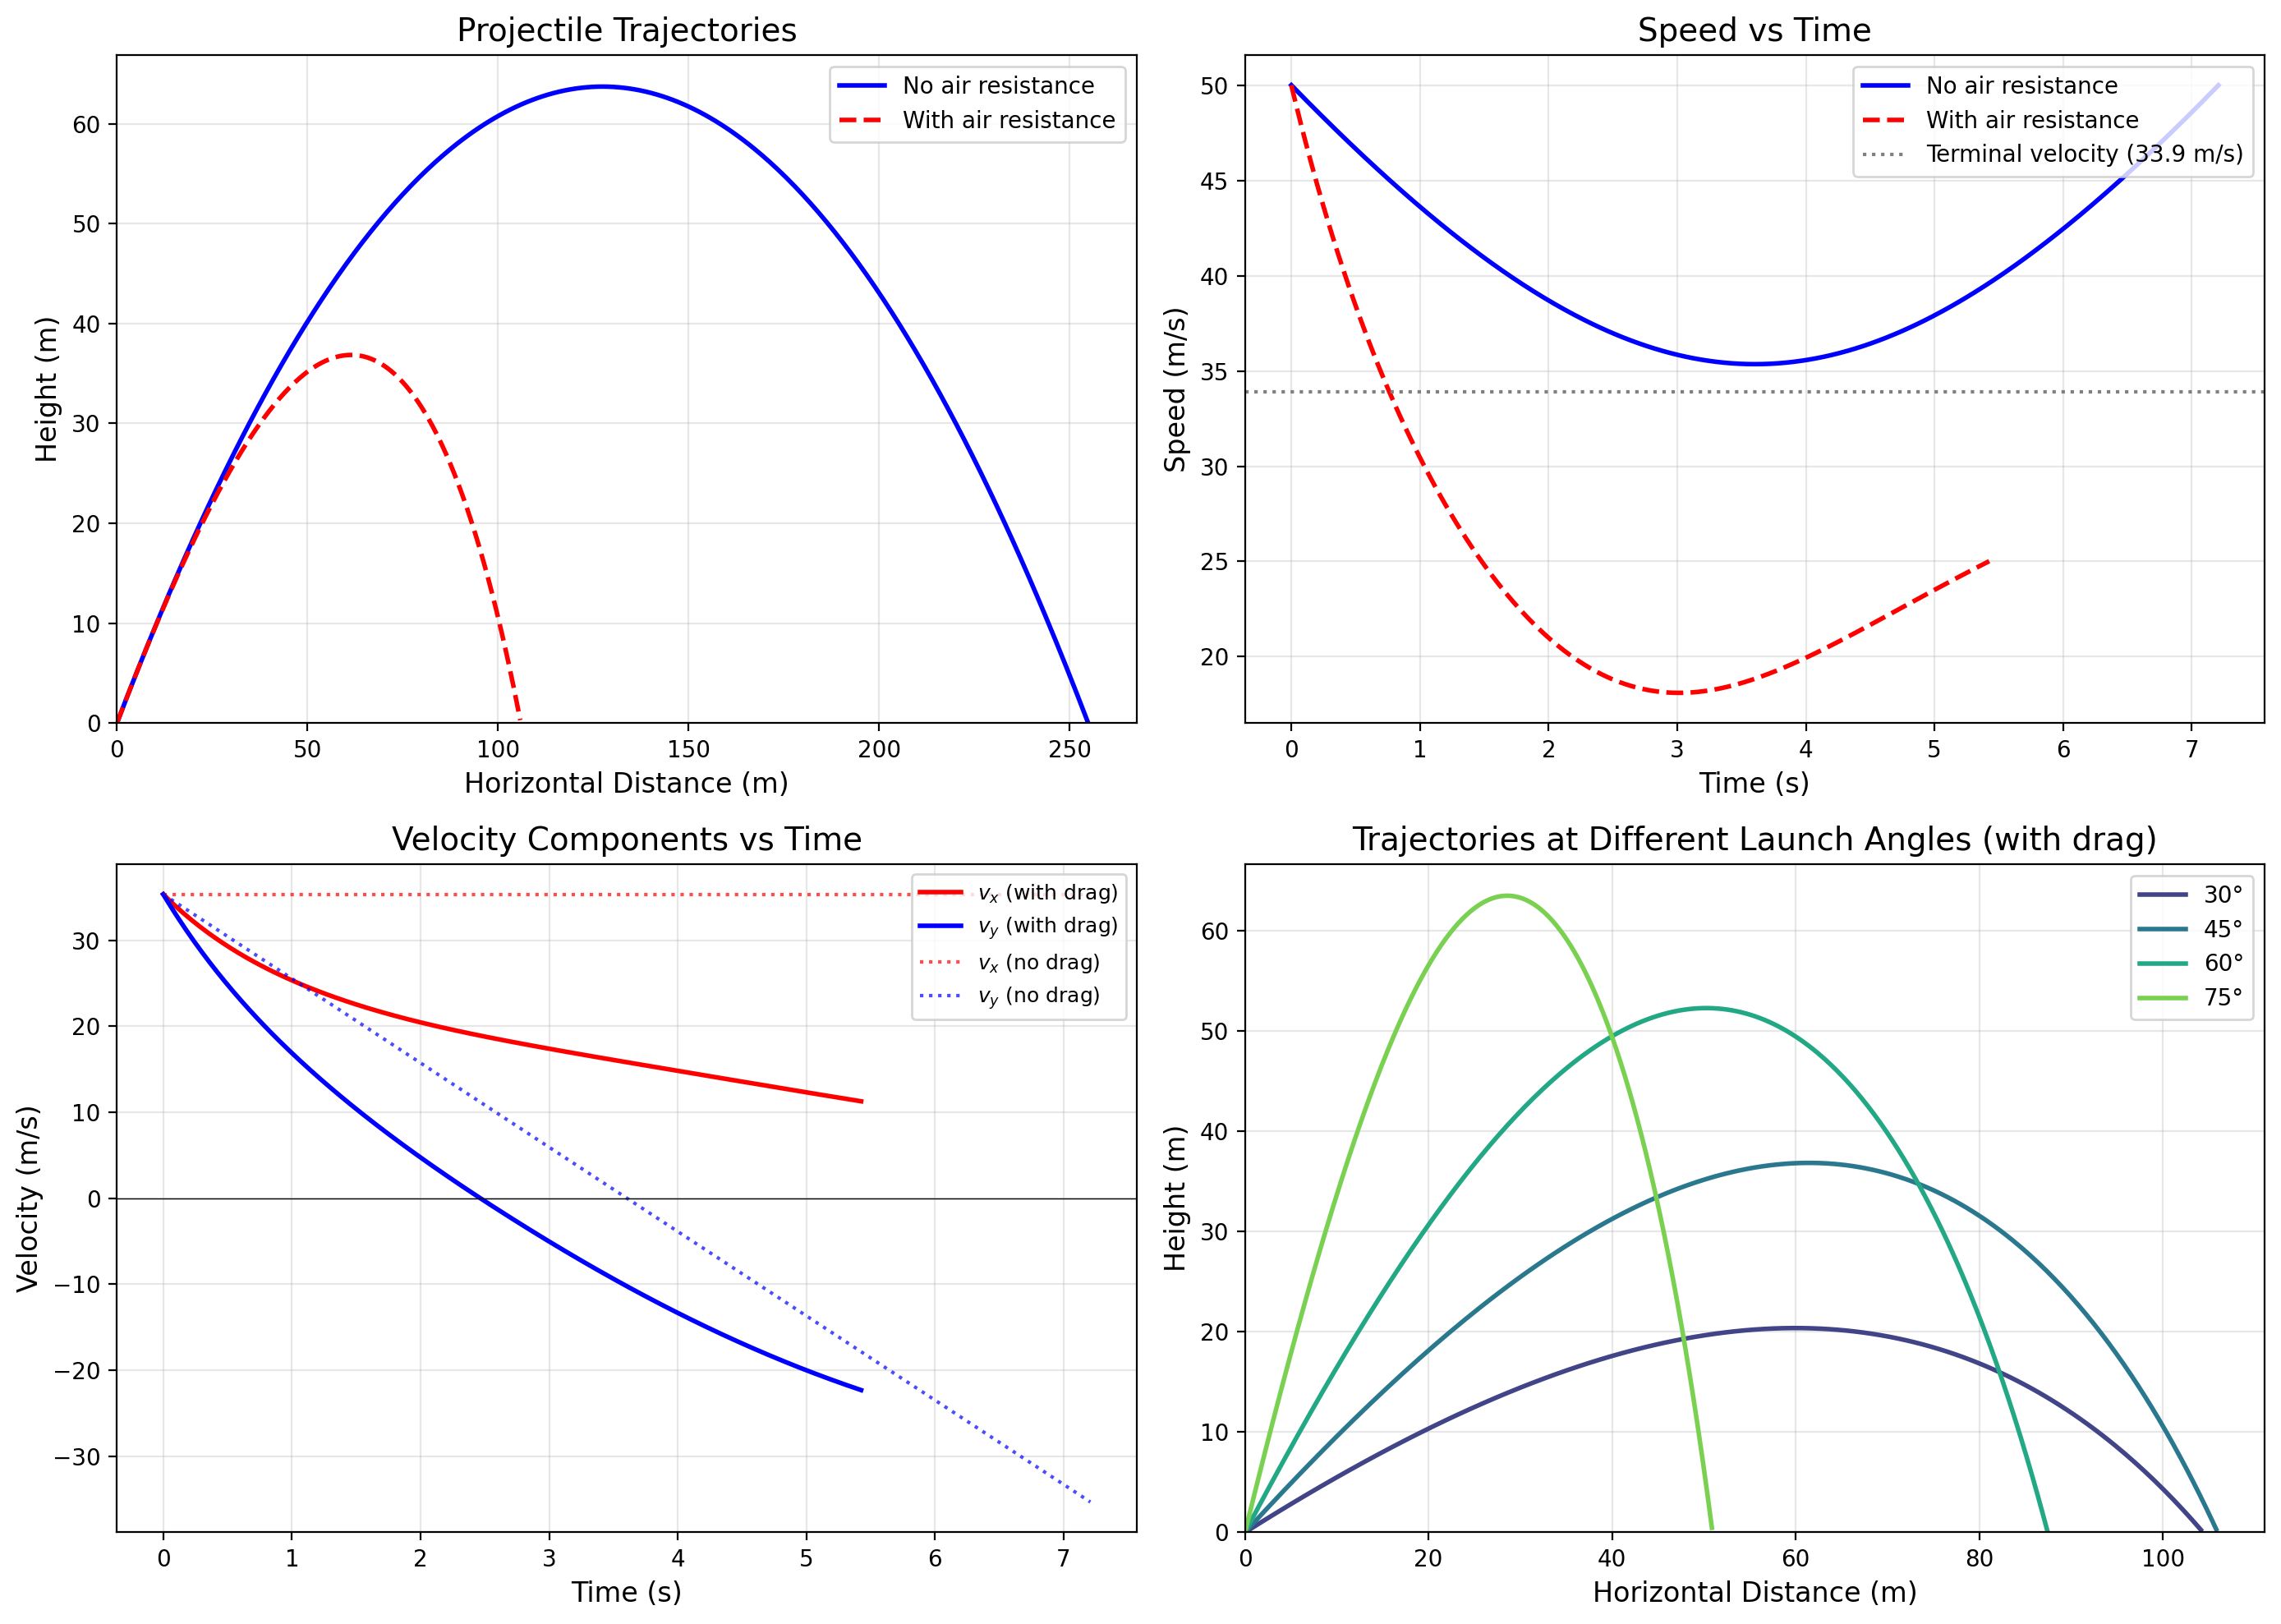


Plot saved to 'plot.png'


In [6]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Trajectory comparison
ax1 = axes[0, 0]
ax1.plot(x_no_drag[mask_no_drag], y_no_drag[mask_no_drag], 'b-', 
         label='No air resistance', linewidth=2)
ax1.plot(x_drag[mask_drag], y_drag[mask_drag], 'r--', 
         label='With air resistance', linewidth=2)
ax1.set_xlabel('Horizontal Distance (m)', fontsize=12)
ax1.set_ylabel('Height (m)', fontsize=12)
ax1.set_title('Projectile Trajectories', fontsize=14)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, None)
ax1.set_ylim(0, None)

# Plot 2: Velocity magnitude vs time
ax2 = axes[0, 1]
v_mag_drag = np.sqrt(vx_drag**2 + vy_drag**2)
v_mag_no_drag = np.sqrt(vx_no_drag**2 + vy_no_drag**2)
ax2.plot(t_no_drag[mask_no_drag], v_mag_no_drag[mask_no_drag], 'b-', 
         label='No air resistance', linewidth=2)
ax2.plot(t_drag[mask_drag], v_mag_drag[mask_drag], 'r--', 
         label='With air resistance', linewidth=2)
ax2.axhline(y=np.sqrt(g/b), color='gray', linestyle=':', 
            label=f'Terminal velocity ({np.sqrt(g/b):.1f} m/s)')
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Speed (m/s)', fontsize=12)
ax2.set_title('Speed vs Time', fontsize=14)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Plot 3: Velocity components
ax3 = axes[1, 0]
ax3.plot(t_drag[mask_drag], vx_drag[mask_drag], 'r-', 
         label='$v_x$ (with drag)', linewidth=2)
ax3.plot(t_drag[mask_drag], vy_drag[mask_drag], 'b-', 
         label='$v_y$ (with drag)', linewidth=2)
ax3.plot(t_no_drag[mask_no_drag], vx_no_drag[mask_no_drag], 'r:', 
         label='$v_x$ (no drag)', linewidth=1.5, alpha=0.7)
ax3.plot(t_no_drag[mask_no_drag], vy_no_drag[mask_no_drag], 'b:', 
         label='$v_y$ (no drag)', linewidth=1.5, alpha=0.7)
ax3.axhline(y=0, color='black', linewidth=0.5)
ax3.set_xlabel('Time (s)', fontsize=12)
ax3.set_ylabel('Velocity (m/s)', fontsize=12)
ax3.set_title('Velocity Components vs Time', fontsize=14)
ax3.legend(loc='upper right', fontsize=9)
ax3.grid(True, alpha=0.3)

# Plot 4: Multiple launch angles comparison (with drag)
ax4 = axes[1, 1]
angles = [30, 45, 60, 75]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(angles)))

for angle, color in zip(angles, colors):
    theta_rad_temp = np.radians(angle)
    vx0_temp = v0 * np.cos(theta_rad_temp)
    vy0_temp = v0 * np.sin(theta_rad_temp)
    
    sol_temp = solve_ivp(
        projectile_with_drag,
        t_span,
        [0.0, 0.0, vx0_temp, vy0_temp],
        args=(b, g),
        t_eval=t_eval,
        events=ground_event
    )
    
    x_temp, y_temp = sol_temp.y[0], sol_temp.y[1]
    mask_temp = y_temp >= 0
    ax4.plot(x_temp[mask_temp], y_temp[mask_temp], 
             label=f'{angle}°', linewidth=2, color=color)

ax4.set_xlabel('Horizontal Distance (m)', fontsize=12)
ax4.set_ylabel('Height (m)', fontsize=12)
ax4.set_title('Trajectories at Different Launch Angles (with drag)', fontsize=14)
ax4.legend(loc='upper right')
ax4.grid(True, alpha=0.3)
ax4.set_xlim(0, None)
ax4.set_ylim(0, None)

plt.tight_layout()
plt.savefig('plot.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Key Observations

1. **Reduced Range**: Air resistance significantly reduces the horizontal range of the projectile. The trajectory is no longer symmetric about the apex.

2. **Lower Maximum Height**: The projectile reaches a lower maximum height because the drag force opposes upward motion.

3. **Asymmetric Trajectory**: Unlike ideal projectile motion, the descent is steeper than the ascent. This is because during descent, drag opposes gravity, slowing the fall.

4. **Velocity Decay**: The horizontal velocity component continuously decreases due to drag (unlike ideal motion where it remains constant).

5. **Optimal Angle Shift**: With air resistance, the optimal launch angle for maximum range shifts below 45°, typically around 35-40° depending on the drag coefficient.

6. **Terminal Velocity**: If the projectile were to fall for sufficient time, it would approach terminal velocity where drag balances gravity.

## Applications

- Sports physics (baseball, golf, tennis)
- Ballistics and artillery
- Aerospace engineering
- Weather balloon trajectories
- Skydiving and parachute design